# Uncertainty of efficiency  from fitted decay yields

We derive an approximate formula to compute the uncertainty of the efficiency computed from fitted yields of some decays. The formula is suitable to draw error bars in plots.

In [1]:
#!pip install numpy iminuit numba_stats matplotlib scipy sympy joblib
import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL, NormalConstraint
from numba_stats import bernstein, norm
from matplotlib import pyplot as plt
import joblib
from sympy import *

## Introduction

The efficiency of a selection is

$$
\epsilon = \frac{k}{n},
$$

where $k$ is the number of events which pass and $n$ is the total number of events.

For the sake of computing confidence intervals for an efficiency computed from a sample, $\epsilon$ is typically assumed to be a [binomial proportion](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval). This means that $k$ is binomially distributed for fixed $n$ in repeated experiments.

In practice, this assumption is usually incorrect. The efficiency is usually computed from a total sample of events whose number $n$ is Poisson distributed, since experiments that involve random processes are typically run for a fixed time rather than until a fixed number of events has occured. This produces a larger variance for $\epsilon$ compared to what is expected from the binomial model.

We demonstrate this numerically.

1.1395442804276614
1.0638370186185993
1.0046267505795776


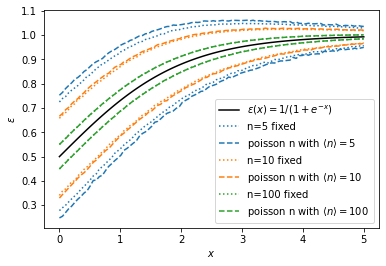

In [2]:
rng = np.random.default_rng(1)

x = np.linspace(0, 5, 100)

# sigmoid
p = 1.0 / (1.0 + np.exp(-x))

plt.plot(x, p, color="k", label=r"$\epsilon(x) = 1/(1 + e^{-x})$")

ntry = 10000
for i, n in enumerate((5, 10, 100)):
    eff1 = []
    eff2 = []
    for pi in p:
        y1 = rng.binomial(n, pi, size=ntry) / n

        ni = rng.poisson(n, size=ntry)
        with np.errstate(invalid="ignore"):
            y2 = rng.binomial(ni, pi) / ni

        for y, eff in [(y1, eff1), (y2, eff2)]:
#             q = np.nanquantile(y, [0.16, 1-0.16])
            m = np.nanmean(y)
            s = np.nanstd(y)
            eff.append((m - s, m + s))
    eff1 = np.array(eff1)
    eff2 = np.array(eff2)

    col = f"C{i}"
    for eff, ls, label in ((eff1, ":", f"n={n} fixed"), 
                           (eff2, "--", f"poisson n with $\\langle n \\rangle = {n}$ ")):
        plt.plot(x, eff[:, 0], color=col, ls=ls, label=label)
        plt.plot(x, eff[:, 1], color=col, ls=ls)

    print(np.mean(np.diff(eff2, axis=1) / np.diff(eff1, axis=1)))

plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$\epsilon$");

Shown is an sigmoidal efficiency curve and a normal approximation interval computed from the standard deviation of the sample estimate $\hat \epsilon$. For small $n$, the interval is wider if $n$ is Poisson distributed.

We compute the variance of $\epsilon$ for both cases explicitly. In the following, it will be important to clearly distinguish sample values from their population values. We will use $\hat x$ for the sample value, which has a population value $x$. The sample value of the efficiency then is $\hat \epsilon = \hat k / \hat n$.

## No background, n fixed

If $\hat n = n$ is fixed, the variance of $\hat \epsilon$ can be computed from the variance of the binomial distribution $\text{var}(\hat k) = n \epsilon (1 - \epsilon)$. We expand the formula for $\epsilon$ in a Taylor series in the variable $k = \epsilon n$ around the sample value $\hat k$ and obtain

$$
\epsilon = \sum_{i=0}^{\infty} \frac {(k - \hat k) ^i}{i!} \frac{\partial^i \epsilon}{\partial {k}^i}(\hat k) = \hat \epsilon + \frac {k - \hat k} n.
$$

The series naturally break off after the first order. Thanks to that, we can compute the variance of $\hat \epsilon$ exactly,

$$
\text{var}(\hat\epsilon) = \text{E}\big((\hat \epsilon - \epsilon)^2\big) = \text{E}\left(\frac{(\hat k - k)^2}{n^2}\right) = \frac{\text{E}\big((\hat k - k)^2\big)}{n^2} = \frac{\text{var}(\hat k)}{n^2} = \frac{\epsilon (1 - \epsilon)}{n}
$$

The same result is obtain with the standard error propagation formula, which is exact in this case, since $\epsilon$ is a linear function of $k$. We performed the calculation from first principles instead of using this formula, because it is instructive for the next step, where $\epsilon$ becomes a non-linear function.

## No background, n Poisson distributed

To simplify the calculation, we use that the efficiency can be written in terms of two independently Poisson-distributed numbers, the number of successes $n_1$ and failures $n_2$,

$$
\epsilon = \frac{n_1}{n_1 + n_2} = \frac{n_1}{n},
$$

with $n = n_1 + n_2$.

In a particular sample, the sample values $\hat n_k$ will deviate from the expectation values $n_k$ by random offsets $d_k = \hat n_k - n_k$. This has an effect on the estimator $\hat \epsilon(\hat n_1, \hat n_2) = \hat n_1 / (\hat n_1 + \hat n_2)$, that we can evaluate by expanding the formula around the true values in a two-dimensional Taylor series with $\hat n_k = n_k$, treating the integer values $\hat n_k$ like real numbers, 

$$
\hat \epsilon = \sum_{i=0}^\infty\sum_{j=0}^\infty \frac {d_1^i \,d_2^j}{i! \, j!} \frac{\partial^{i+j} \hat \epsilon}{\partial \hat n_1^i \partial \hat n_2^j} (n_1, n_2)
$$

In [442]:
def bivariate_series(expr, x, y, dx, dy, order_max):
    return sum(
        sum(
            dx ** i * dy ** j / 
            (factorial(i) * factorial(j)) *
            diff(expr, x, i, y, j)
            for i in range(order_max + 1)
            if (i + j) <= order_max
        ) for j in range(order_max + 1)
    )

In [443]:
n1, n2, n, epsilon = symbols("n_1 n_2 n epsilon", real=True, nonnegative=True)
d1, d2 = symbols("d_1 d_2", real=True)

eps = n1 / (n1 + n2)

delta_eps = (bivariate_series(eps, n1, n2, d1, d2, 7) - eps)
delta_eps = delta_eps.subs([(n1, epsilon * n), (n2, (1-epsilon) * n)])
delta_eps = delta_eps.as_poly([d1, d2])
delta_eps

Poly((1 - epsilon)/n**7*d_1**7 + (6 - 7*epsilon)/n**7*d_1**6*d_2 + (epsilon - 1)/n**6*d_1**6 + (15 - 21*epsilon)/n**7*d_1**5*d_2**2 + (6*epsilon - 5)/n**6*d_1**5*d_2 + (1 - epsilon)/n**5*d_1**5 + (20 - 35*epsilon)/n**7*d_1**4*d_2**3 + (15*epsilon - 10)/n**6*d_1**4*d_2**2 + (4 - 5*epsilon)/n**5*d_1**4*d_2 + (epsilon - 1)/n**4*d_1**4 + (15 - 35*epsilon)/n**7*d_1**3*d_2**4 + (20*epsilon - 10)/n**6*d_1**3*d_2**3 + (6 - 10*epsilon)/n**5*d_1**3*d_2**2 + (4*epsilon - 3)/n**4*d_1**3*d_2 + (1 - epsilon)/n**3*d_1**3 + (6 - 21*epsilon)/n**7*d_1**2*d_2**5 + (15*epsilon - 5)/n**6*d_1**2*d_2**4 + (4 - 10*epsilon)/n**5*d_1**2*d_2**3 + (6*epsilon - 3)/n**4*d_1**2*d_2**2 + (2 - 3*epsilon)/n**3*d_1**2*d_2 + (epsilon - 1)/n**2*d_1**2 + (1 - 7*epsilon)/n**7*d_1*d_2**6 + (6*epsilon - 1)/n**6*d_1*d_2**5 + (1 - 5*epsilon)/n**5*d_1*d_2**4 + (4*epsilon - 1)/n**4*d_1*d_2**3 + (1 - 3*epsilon)/n**3*d_1*d_2**2 + (2*epsilon - 1)/n**2*d_1*d_2 + (1 - epsilon)/n*d_1 - epsilon/n**7*d_2**7 + epsilon/n**6*d_2**6 - epsilo

To compute the variance $\text{var}(\hat \epsilon)$ we need to square this and compute the expection on both sides. We use that $\text{E}(d_1^i d_2^j) = \text{E}(d_1^i) \, \text{E}(d_2^j)$, since $\hat n_1$ and $\hat n_2$ are independently sampled. The expectation value $\text{E}(d_k^j)$ is the $j$-th central moment of the Poisson distribution with $\lambda = n_k$. These moments are Touchard polynomials, which are conveniently computed with a recursion formula.

In [444]:
# compute mapping d_k ** i -> E[d_k ** i]

def central_moments(n):
    x = symbols("x")
    r = [1]
    for ni in range(n):
        # recursion for Touchard polynomial
        m = x * sum(binomial(ni, k) * r[k] for k in range(ni))
        r.append(m.expand())

    return [lambdify([x], ri) for ri in r]

replacements = central_moments(14)

Now we compute $\text{var}(\hat \epsilon) = \text{E}\big((\hat \epsilon - \epsilon)^2\big)$. Since SymPy does not know how to compute an expectation and that it is a linear operator, we need to resort to advanced expression manipulation in the following steps. We use that the expectation is linear and $\text{E}(n_i n_j) = \text{E}(n_i) \, \text{E}(n_j)$ for independent $n_i$ and $n_j$.

In [445]:
def expectation(expr, args, args2, replacements):
    poly = expr.as_poly(args)
    expr2 = []
    for powers, coef in poly.terms():
        x = prod(
            1 if pi == 0 else replacements[pi](argi)
            for pi, argi in zip(powers, args2)
        )
        expr2.append(coef * x)
    return sum(expr2)

In [446]:
# replace powers of d_k with the corresponding central moments
expr2 = expectation(delta_eps ** 2, (d1, d2), (epsilon * n, (1-epsilon)*n), replacements)
expr2 = expr2.as_poly(1/n)
expr2

Poly((-epsilon**2 + epsilon)*(1/n)**13 + (-4081*epsilon**2 + 4081*epsilon)*(1/n)**12 + (-233058*epsilon**2 + 233058*epsilon)*(1/n)**11 + (-1413895*epsilon**2 + 1413895*epsilon)*(1/n)**10 + (-1356075*epsilon**2 + 1356075*epsilon)*(1/n)**9 + (-130095*epsilon**2 + 130095*epsilon)*(1/n)**8 + (720*epsilon**2 - 720*epsilon)*(1/n)**7 + (118*epsilon**2 - 118*epsilon)*(1/n)**6 + (-24*epsilon**2 + 24*epsilon)*(1/n)**5 + (-6*epsilon**2 + 6*epsilon)*(1/n)**4 + (-2*epsilon**2 + 2*epsilon)*(1/n)**3 + (-epsilon**2 + epsilon)*(1/n)**2 + (-epsilon**2 + epsilon)*(1/n), 1/n, domain='ZZ[epsilon]')

We keep only terms up to $O(1/n^2)$.

In [447]:
expr3 = []
for (p, ), coef in expr2.terms():
    if p <= 2:
        expr3.append(coef * n ** -p)
eps_var = sum(expr3).subs(epsilon, n1/n).subs(n, n1 + n2).simplify()
eps_var

n_1*n_2*(n_1 + n_2 + 1)/(n_1 + n_2)**4

Up to the extra factor $(n + 1)/n$, this is the variance of the binomial distribution we derived previously.

This formula is accurate for $n > 10$. To get accurate results at even smaller $n$, we need to include to higher orders.

In [448]:
expr3 = []
for (p, ), coef in expr2.terms():
    if p <= 4:
        expr3.append(coef * n ** -p)
eps_var = sum(expr3).subs(epsilon, n1/n).subs(n, n1 + n2).simplify()
eps_var

n_1*n_2*(2*n_1 + 2*n_2 + (n_1 + n_2)**3 + (n_1 + n_2)**2 + 6)/(n_1 + n_2)**6

This formula is accurate down to $n \ge 5$.

The values $n_k$ that appear in the formula are the unknown expectation values and need to be replaced by their sample estimates $\hat n_k$ in practice. This is an application of the plug-in principle on which also bootstrap theory is based. There is a small bias involved in doing this, but it is negligible here.

In [449]:
eps_var_py = lambdify((n1, n2), eps_var)

In [450]:
rng = np.random.default_rng(1)
eps = np.linspace(0, 1, 100)
data = {}
for n in (5, 10, 20, 50, 100, 1000):
    s1 = []
    s2 = []
    for epsi in eps:
        n1 = n * epsi
        n2 = n * (1 - epsi)
        k1 = rng.poisson(n1, size=10000)
        k2 = rng.poisson(n2, size=10000)
        ma = k1 + k2 > 0
        k1 = k1[ma]
        k2 = k2[ma]
        s1.append(np.std(k1 / (k1 + k2)))
        # it is important to average the variance instead of the standard deviation
        s2.append(np.mean(eps_var_py(k1, k2)) ** 0.5)
    data[n] = np.array((eps, s1, s2))

n=5 median deviation 0.00
n=10 median deviation -0.01
n=20 median deviation -0.00
n=50 median deviation -0.00
n=100 median deviation 0.00
n=1000 median deviation 0.00


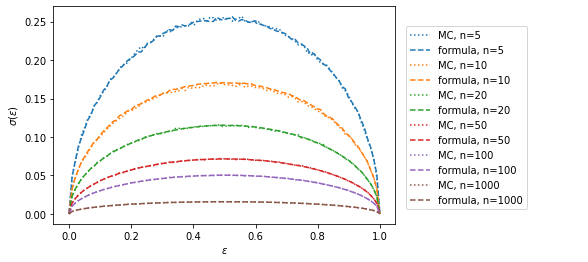

In [451]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"formula, {n=}")
    print(f"{n=} median deviation {np.median(s1[s2 > 0] / s2[s2 > 0]) - 1:.2f}")
plt.subplots_adjust(right=0.6)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\sigma(\epsilon)$")
plt.figlegend(loc=(0.69, 0.2));

### Wilson interval

To-do.

## With background

We now assume that the estimates $\hat n_1$ and $\hat n_2$ cannot obtained by direct counting, but need to be estimated from a fit that inclues a signal and background component. If the fit is unbiased, the average contribution from the background is zero, which we will assume, but it enlargens the uncertainty of the estimate.

We can model this by adding a random contribution from the background to our estimate,

$$
\hat n = n + z_1 \sigma_\text{poisson} + z_2 \sigma_\text{bkg} = n + z_1 \sqrt{n} + z_2 \sigma_\text{bkg},
$$

where $z_1$ and $z_2$ are independent random variables with zero mean and unit variance.

The expected variance of $\hat n$ then is

$$
\sigma^2(\hat n) = n + \sigma^2_\text{bkg}.
$$

In practice, estimating $\sigma^2_\text{bkg}$ directly is difficult, but fortunately, the left-hand side $\sigma^2(\hat n)$ can be estimated from the fit (MINUITs Hesse error). Thus we can compute an estimate for the unknown $\sigma^2_\text{bkg}$ with the formula,

$$
\sigma^2_\text{bkg} = \sigma^2(\hat n) -  n.
$$

In practice, we have to replace the expectation values $\sigma^2(\hat n)$ and $n$ with the corresponding estimates from the fit.

We insert this into the formula for $\hat \epsilon$ and get:

$$
\hat \epsilon = \frac{\hat n_1}{\hat n_1 + \hat n_2} = \frac{n_1 + z_1 \sqrt{n_1} + z_2 \sigma_\text{bkg,1}}{n_1 + n_2 + z_1 \sqrt{n_1} + z_2 \sigma_\text{bkg,1} + z_3 \sqrt{n_2} + z_4 \sigma_\text{bkg,2}}
$$

As before, the variance of $\hat \epsilon$ is computed via standard error propagation, using that the $z_i$ are independent and standard normal. This reflects the assumption that the background in both fits is independently sampled, which in practice is usually not exactly true. If the correlation can be estimated, it can be trivially included in the calculation, but I will not do this here.

$$
\sigma^2(\hat \epsilon) = \left[\left(\frac{\text{d}\hat \epsilon}{\text{d}z_1}\right)^2 + \left(\frac{\text{d}\hat \epsilon}{\text{d}z_2}\right)^2 + 
\left(\frac{\text{d}\hat \epsilon}{\text{d}z_3}\right)^2 +
\left(\frac{\text{d}\hat \epsilon}{\text{d}z_4}\right)^2
\right]_{z_1 = 0,\, z_2=0,\,z_3=0,\,z_4=0}.
$$

In [427]:
(n1, n2, sigma1, sigma2,
 sigma_bkg1, sigma_bkg2,
 z1, z2, z3, z4) = symbols(
    "n_1 n_2 sigma_1 sigma_2 "
    "sigma_bkg_1 sigma_bkg_2 "
    "z_1 z_2 z_3 z_4", real=True)

g = (n1 + z1 * sqrt(n1) + z2 * sigma_bkg1) / \
    (n1 + n2
     + z1 * sqrt(n1) + z2 * sigma_bkg1 
     + z3 * sqrt(n2) + z4 * sigma_bkg2); g

(sqrt(n_1)*z_1 + n_1 + sigma_bkg_1*z_2)/(sqrt(n_1)*z_1 + n_1 + sqrt(n_2)*z_3 + n_2 + sigma_bkg_1*z_2 + sigma_bkg_2*z_4)

In [429]:
g = g.subs([(sigma_bkg1, sqrt(sigma1 ** 2 - n1)), 
            (sigma_bkg2, sqrt(sigma2 ** 2 - n2))]); g

(sqrt(n_1)*z_1 + n_1 + z_2*sqrt(-n_1 + sigma_1**2))/(sqrt(n_1)*z_1 + n_1 + sqrt(n_2)*z_3 + n_2 + z_2*sqrt(-n_1 + sigma_1**2) + z_4*sqrt(-n_2 + sigma_2**2))

In [430]:
g_var = sum(diff(g, z) ** 2 for z in (z1, z2, z3, z4))
g_var = g_var.subs([(z1, 0), (z2, 0), (z3, 0), (z4, 0)])
g_var = g_var.simplify(); g_var

(n_1**2*sigma_2**2 + n_2**2*sigma_1**2)/(n_1 + n_2)**4

We thus obtain

$$
\sigma(\hat \epsilon) = \frac{\sqrt{
n_1^2 \, \sigma^2(\hat n_2) +
n_2^2 \, \sigma^2(\hat n_1)
}}{n^2},
$$

with $n = n_1 + n_2$. In practice, $n_1$, $\sigma^2(\hat n_1)$, ...  need to be replaced with their fit estimates.

As a check, I show how one can recover the previous formula, which is a special case, by setting $\sigma^2(\hat n_k) = n_k$ (which means no background contribution),

$$
\sigma^2(\hat \epsilon) = \frac{
n_1^2 \, \sigma^2(\hat n_2) +
n_2^2 \, \sigma^2(\hat n_1)
}{n^4} = 
\frac{
n_1^2 \, n_2 +
n_2^2 \, n_1
}{n^4} =
\frac{
n_1 \, n_2 \, (n_1 + n_2)
}{n^4} =
\frac{
n_1 \, n_2
}{n^3}.
$$

We again check the formula against Monte-Carlo simulations.

In [431]:
g_var_py = lambdify([n1, sigma1, n2, sigma2], g_var)

In [432]:
def model(x, b0, b1, b2, s, mu, sigma):
    nb = bernstein.scaled_cdf(x, (b0, b1, b2), -1, 1)
    ns = s * norm.cdf(x, mu, sigma)
    return ns + nb

@joblib.delayed
def run(eps, n):
    rng = np.random.default_rng(1)

    t1 = []
    t2 = []
    for itry in range(100):
        sigma = 0.1
        results = []
        for p in (eps, 1 - eps):
            s = rng.normal(0, sigma, size=rng.poisson(p * n))
            b = rng.uniform(-1, 1, size=n // 5)
            x = np.append(s, b)
            w, xe = np.histogram(x, bins=50, range=(-1, 1))
            cost = ExtendedBinnedNLL(w, xe, model)
            cost += NormalConstraint(("mu", "sigma"), (0, sigma), (1, 1))
            s_start = eps * n
            b_start = n
            m = Minuit(cost, 
                       b0=b_start, b1=b_start, b2=b_start,
                       s=s_start + 1, mu=0, sigma=sigma)
            m.limits[:4] = (0, None)
            m.limits["mu"] = (-0.5, 0.5)
            m.limits["sigma"] = (0.02, 1)
            m.migrad()
            if m.valid and m.accurate:
                results.append((m.values["s"], m.errors["s"]))
            else:
                print(n, f"{eps:.2f}", itry, "signal" if p == eps else "background",
                      "fit failed")
        if len(results) < 2:
            continue

        (n_pass, sigma_pass), (n_fail, sigma_fail) = results

        t1i = n_pass / (n_pass + n_fail)
        t2i = g_var_py(n_pass, sigma_pass, n_fail, sigma_fail)
        t1.append(t1i)
        t2.append(t2i)

    s1 = np.std(t1)
    s2 = np.mean(t2) ** 0.5
    return s1, s2

data = {}
eps = np.linspace(0, 1, 20)
with joblib.Parallel(-1) as pool:
    for n in (50, 100, 1000):
        s1, s2 = np.transpose(pool(run(epsi, n) for epsi in eps))
        data[n] = (eps, s1, s2)

n=50 median deviation 0.02
n=100 median deviation -0.03
n=1000 median deviation 0.04


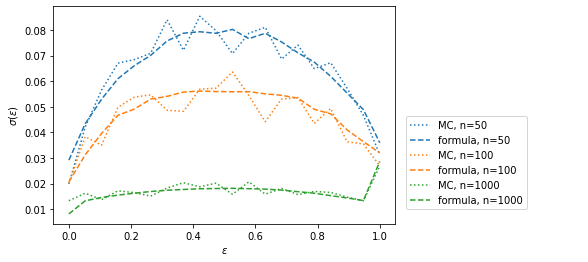

In [433]:
plt.figure(figsize=(10, 4))
for n, (eps, s1, s2) in data.items():
    l, = plt.plot(eps, s1, ":", label=f"MC, {n=}")
    plt.plot(eps, s2, "--", color=l.get_color(), label=f"formula, {n=}")
    print(f"{n=} median deviation {np.median(s1[s2 > 0] / s2[s2 > 0]) - 1:.2f}")
plt.subplots_adjust(right=0.6)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\sigma(\epsilon)$")
plt.figlegend(loc=(0.69, 0.2));

Again, the derived formula does reasonably well with deviations around 5 % for $n > 50$. This is usually sufficient to calculate error bars for efficiency plots. There should be some bias for small $n$ as before, but it is difficult to see here due to other larger random scatter, since I generated less toys to keep the computation time on my laptop reasonable.


Finally, I compare the uncertainty estimates for various levels of background. The estimate with zero background corresponds to the estimate which one obtains with the naive formula.

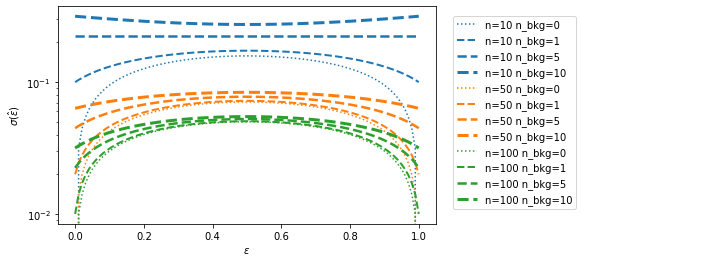

In [434]:
plt.figure(figsize=(14, 4))
eps = np.linspace(0, 1, 100)
for n in (10, 50, 100):
    n_pass = n * eps
    n_fail = n * (1 - eps)
    n_bkg = 0
    col = None
    for i, n_bkg in enumerate((0, 1, 5, 10)):
        s2 = g_var_py(n_pass, (n_pass + n_bkg) ** 0.5, n_fail, (n_fail + n_bkg) ** 0.5) ** 0.5
        col = plt.plot(eps, s2, "--" if i > 0 else ":", color=col,
                       lw=0.5 * i + 1.5, label=f"{n=} {n_bkg=}")[0].get_color()
plt.subplots_adjust(right=0.5)
plt.figlegend(loc=(0.64, 0.2))
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\sigma(\hat \epsilon)$")
plt.semilogy();

The error of using a formula that neglects the background contribution is largest when the efficiency is close to zero or one.

These are frequently the interesting cases. For example, the [tracking efficency of the LHCb experiment]((https://doi.org/10.1088/1748-0221/10/02/P02007)) is estimated from fits to decays in calibration samples and the efficiency is around 96 %, so that the difference in the formulas may impact the estimated uncertainty.

#### Formula for fits to selected and total events

Sometimes it is not easy to split the two samples into failed and passed cases, one has instead fits to the passed and total cases. 

In this case, we need to replace $n_2$ and $\sigma^2(\hat n_2)$ in the main formula for $\sigma(\hat \epsilon)$, since we then only have $n = n_1 + n_2$, $\sigma^2(\hat n)$, $n_1$, and $\sigma^2(\hat n_1)$ available.

Since both estimates $\hat n_1$ and $\hat n_2$ are completely independent (again assuming independent background), their sum $\hat n = \hat n_1 + \hat n_1$ must have the variance $\sigma^2(\hat n) = \sigma^2(\hat n_1) + \sigma^2(\hat n_2)$.

Thus the formula for this case becomes

$$
\sigma(\hat \epsilon) = \frac{\sqrt{
n_1^2 \, (\sigma^2(\hat n) - \sigma^2(\hat n_1)) +
(n - n_1)^2 \, \sigma^2(\hat n_1)
}}{n^2}.
$$